In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

from subset_helper import subset_helper

**<font color='blue'>Notebook description</font>**

<font color='blue'>We build a predictive model for the number of death using random forest, and assess its performance.</font>

In [2]:
# import data
mortality = pd.read_csv('../data/mortality_merged.csv')

**<font color='green'>Preprocessing steps</font>**

In [3]:
mortality = subset_helper(mortality).subset()

In [4]:
# Train-test split
TEST_SIZE = 0.2
SEED = 467051528
X_train, X_test, y_train, y_test = train_test_split(mortality.drop('COUNT', axis = 1), 
                                                    mortality['COUNT'], 
                                                    test_size = TEST_SIZE,
                                                    random_state = SEED,
                                                    shuffle = True)

In [5]:
# Preprocessing steps
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler())
])
categorical_transformer = OneHotEncoder(drop = 'first')

categorical_features = ['REGION', 'AGE-GROUP', 'SEX', 'COD']
numeric_features = X_train.columns.to_list()[6:]

preprocessor = ColumnTransformer(
    transformers = [
        ('drop_columns', 'drop', ['YEAR', 'MONTH']),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

**<font color='green'>Hyperparameters tuning</font>**

In [6]:
# Parameter grids
n = np.arange(1, 16)
max_f = np.arange(5, 10)
params = {'preprocessing__num' : [StandardScaler(), RobustScaler()], 
         'regressor__max_features': max_f}

In [7]:
# Model
SEED_RF = 20210525
model = Pipeline(steps = [
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators = 300, random_state = SEED_RF))
])

In [8]:
# Grid search
search = RandomizedSearchCV(model, 
                            param_distributions = params, 
                            random_state = SEED)
search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('drop_columns',
                                                                               'drop',
                                                                               ['YEAR',
                                                                                'MONTH']),
                                                                              ('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['TEMP_MEAN',
                                                                                'TEMP_RNG',
                                                                                'W

In [9]:
# Summary of grid search
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_features,param_preprocessing__num,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.628618,0.003068,0.032196,0.000196,5,StandardScaler(),"{'regressor__max_features': 5, 'preprocessing_...",0.938281,0.957287,0.955427,0.945367,0.939471,0.947167,0.007900,9
1,0.677443,0.002907,0.031427,0.000940,6,StandardScaler(),"{'regressor__max_features': 6, 'preprocessing_...",0.958123,0.970866,0.967425,0.959189,0.963235,0.963768,0.004835,8
2,0.720755,0.002876,0.030061,0.001796,7,StandardScaler(),"{'regressor__max_features': 7, 'preprocessing_...",0.968380,0.975616,0.977590,0.968567,0.973372,0.972705,0.003704,5
3,0.766813,0.002175,0.031351,0.001979,8,StandardScaler(),"{'regressor__max_features': 8, 'preprocessing_...",0.971521,0.978041,0.980980,0.975260,0.979593,0.977079,0.003366,4
4,0.824638,0.016219,0.031037,0.001774,9,StandardScaler(),"{'regressor__max_features': 9, 'preprocessing_...",0.975453,0.979125,0.982926,0.976068,0.983912,0.979497,0.003450,2
5,0.628294,0.002613,0.031636,0.001886,5,RobustScaler(),"{'regressor__max_features': 5, 'preprocessing_...",0.938266,0.957183,0.955418,0.945382,0.939325,0.947115,0.007903,10
6,0.677421,0.003188,0.031705,0.001964,6,RobustScaler(),"{'regressor__max_features': 6, 'preprocessing_...",0.958028,0.971029,0.967467,0.959311,0.963201,0.963807,0.004889,7
7,0.724690,0.003733,0.031666,0.000739,7,RobustScaler(),"{'regressor__max_features': 7, 'preprocessing_...",0.968313,0.975583,0.977621,0.968669,0.973315,0.972700,0.003699,6
8,0.771121,0.002768,0.031689,0.000764,8,RobustScaler(),"{'regressor__max_features': 8, 'preprocessing_...",0.971513,0.978073,0.981003,0.975343,0.979500,0.977086,0.003354,3
9,0.819383,0.001107,0.032354,0.001439,9,RobustScaler(),"{'regressor__max_features': 9, 'preprocessing_...",0.975505,0.979197,0.982943,0.976104,0.983859,0.979522,0.003419,1


In [10]:
# Best fitted scores
print(search.best_params_)
print('Best scores: ', search.best_score_)

{'regressor__max_features': 9, 'preprocessing__num': RobustScaler()}
Best scores:  0.9795216033170174


**<font color='green'>Performance assessment</font>**

In [11]:
# Test performance
model_chosen = search.best_estimator_
y_pred = model_chosen.predict(X_test)

In [12]:
# Test loss
mean_squared_error(y_pred, y_test)

118.80220984444445

In [13]:
# Training loss
mean_squared_error(y_train, model_chosen.predict(X_train))

15.289794188376753

C:\Users\user\anaconda3\envs\mda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='COUNT'>

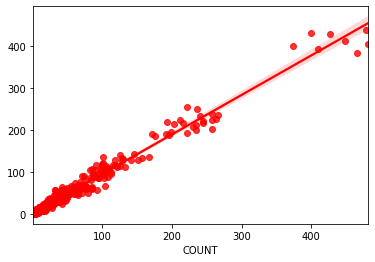

In [14]:
# Test data: y_test, y_pred
sns.regplot(y_test, y_pred, color = 'red')

In [15]:
# R-squared between y_pred and y_test
np.corrcoef(y_test, y_pred)

array([[1.        , 0.98988437],
       [0.98988437, 1.        ]])

<AxesSubplot:xlabel='COUNT'>

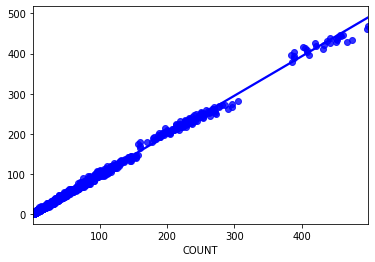

In [16]:
# Training data: y_test, y_pred_train
y_pred_train = model_chosen.predict(X_train)
sns.regplot(x = y_train, y = y_pred_train, color = 'blue')

In [17]:
# R-squared between y_pred and y_pred_train
np.corrcoef(y_train, y_pred_train)

array([[1.        , 0.99874573],
       [0.99874573, 1.        ]])